In [4]:
#load-in the data
import numpy as np
from astropy.stats import LombScargle
import matplotlib.pyplot as plt
%matplotlib inline
# Read the data
date, rv, rverr, ha, haerr, nad, naderr, fwhm, fwhmerr, bis, biserr = \
    np.loadtxt("./data/dbf_HARPS.txt", unpack=True, \
    usecols=[1,2,3,4,5,6,7,8,9,10,11], skiprows=21)
dateH, rvH, rverrH, haH, haerrH = \
    np.loadtxt("./data/dbf_HIRES.txt", unpack=True, \
    usecols=[1,2,3,4,5])
first = date[0]
date -= first
dateH -= first
# Put together the HIRES and HARPS measurements of RV and Halpha
alldates = np.concatenate((date, dateH))
allRV = np.concatenate((rv, rvH))
allRVerr = np.concatenate((rverr, rverrH))
allha = np.concatenate((ha, haH))
allhaerr = np.concatenate((haerr, haerrH))
sub = np.argsort(alldates)
alldates = alldates[sub]
allRV = allRV[sub]
allRVerr = allRVerr[sub]
allha = allha[sub]
allhaerr = allhaerr[sub]
# Compute the periodograms
xiR, powR = LombScargle(alldates, allRV, allRVerr).autopower()
xiH, powH = LombScargle(alldates, allha, allhaerr).autopower()

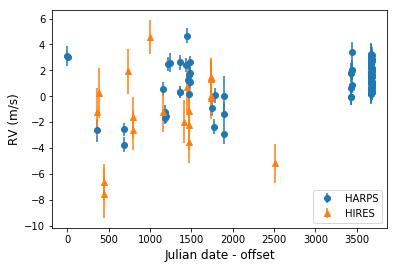

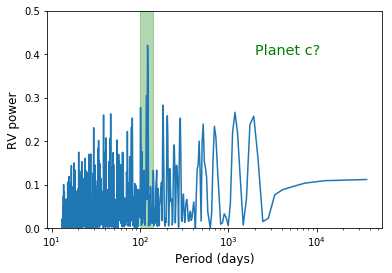

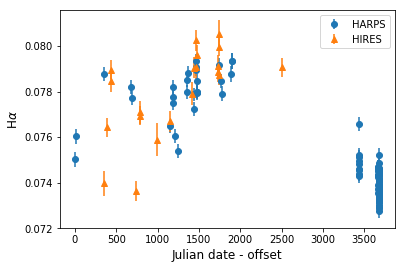

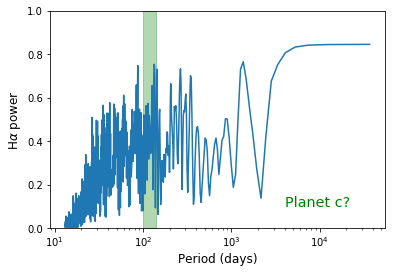

In [5]:
# Plot RV and periodogram
xpts = [101, 106, 111, 116, 121, 126, 131, 136, 141]
ypts = np.ones(9)
plt.figure()
plt.errorbar(date, rv, yerr=rverr, fmt='o', label="HARPS")
plt.errorbar(dateH, rvH, yerr=rverrH, fmt='^', label="HIRES")
plt.legend(loc="lower right")
plt.ylabel("RV (m/s)", fontsize='large')
plt.xlabel("Julian date - offset", fontsize="large")
plt.figure()
plt.plot(1./xiR, powR)
plt.fill_between(xpts, ypts, color="g", alpha=0.3)
plt.ylim([0,0.5])
plt.ylabel("RV power", fontsize="large")
plt.xlabel("Period (days)", fontsize="large")
plt.text(2000,0.4,"Planet c?", color="g", fontsize="x-large")
plt.xscale("log")
plt.figure()
plt.errorbar(date, ha, yerr=haerr, fmt='o', label="HARPS")
plt.errorbar(dateH, haH, yerr=haerrH, fmt='^', label="HIRES")
plt.legend(loc="upper right")
plt.ylabel(r"H$\alpha$", fontsize='large')
plt.xlabel("Julian date - offset", fontsize="large")
plt.figure()
plt.plot(1./xiH, powH)
plt.fill_between(xpts, ypts, color="g", alpha=0.3)
plt.ylim([0,1.])
plt.ylabel(r"H$\alpha$ power", fontsize="large")
plt.xlabel("Period (days)", fontsize="large")
plt.text(4000,0.1,"Planet c?", color="g", fontsize="x-large")
plt.xscale("log")

In [60]:
# To install george: $ conda install -c conda-forge george
# Most of this code is borrowed from a tutorial in the george documentation:
# https://george.readthedocs.io/en/latest/tutorials/hyper/
from george import kernels
from george import GP
from george import modeling
from scipy.optimize import minimize
from scipy.optimize import Bounds

'''Initial guesses for the hyperparameters that give reasonable
converged values--DO NOT DELETE'''

lt_constant = 0.003
lt_metric = 1500000.  #ln(1500000) = 14.22


# Create the kernels
k = lt_constant * kernels.ExpSquaredKernel(metric=lt_metric)


# Trivial functions that return the LN white noise VARIANCE.
# Note: I'm not 100% sure I'm treating the measurement uncertainties correctly.
def whitenoise_RV(time):
    return np.log(allRVerr**2)

def whitenoise_ha(time):
    return np.log(allhaerr**2)

# Initialize the Gaussian processes 
# H-Alpha
gp = GP(k, fit_kernel=True, mean=np.mean(allha))
        #white_noise=modeling.CallableModel(whitenoise_ha, gradient=None))

# Function that takes concatenated vector containing BOTH sets of GP
# parameters and separates it into two, one for each GP
def split_par_vec(par_vec):
    lt_amp = par_vec[0]
    lt_metric = par_vec[1]
    pars = [lt_amp, lt_metric]
    return pars

# Function that takes the two parameter vectors and turns them
# into one master parameter vector
def make_par_vec(pars):
    lt_amp = pars[0]
    lt_metric = pars[1]
    
    master_pars = [lt_amp, lt_metric]
    return master_pars

# Set reasonable boundaries for each hyperparameter
# Bounds order is same as parameter order: longterm amplitude, longterm metric
lower_bounds = [0., 14.2]
upper_bounds = [20., 35.]

# Create a Bounds object that will restrict minimize to values within
# the boundaries
par_bounds = Bounds(lower_bounds, upper_bounds)

# Define the objective function that will be used to evaluate the goodness
# of the fitted hyperparameters (negative log-likelihood in this case)

#H-Alpha
def nll(gpPars):
    p = split_par_vec(gpPars)
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(allha, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# You need to compute both GPs before starting the optimization.
gp.compute(alldates,allhaerr)

# Combine the parameter vectors for both Gaussian processes into
# one (objective function sent to minimize must have only one
# input vector)
pars = gp.get_parameter_vector()
allpars = make_par_vec(pars)
print("Master parameter vector:", allpars)

# Print the initial ln-likelihood
print("Initial ln-likelihood:", -nll(allpars))

# Run the optimization routine. I DON'T THINK USING george's 
# GRAD_LOG_LIKELIHOOD FUNCTION WILL WORK HERE BECAUSE PERIOD AND 
# DECORRELATION TIMESCALE WILL HAVE DIFFERENT GRADIENTS IN THE 
# HALPHA AND RV PARAMETER SETS.
# results = minimize(nll, allpars, jac=grad_nll, method="L-BFGS-B")
results = minimize(nll, allpars, method="TNC", bounds=par_bounds, \
                   options={'maxiter':3000, 'ftol':1.0e-8, 'xtol':1.0e-9, \
                           'gtol':1.0e-8})

# Update the kernels, print the final log-likelihood and results
results_ha = split_par_vec(results.x)
final_loglike = -nll(results.x)
npts = len(alldates)
npars = len(allpars)
bic = np.log(npts) * npars - 2.*final_loglike
print("Final ln-likelihood:", final_loglike)
print(results)
gp.set_parameter_vector(results_ha)
print("\nBayesian information criterion: %4.2f" % bic)

Master parameter vector: [-5.809142990314028, 14.22097566607244]
Initial ln-likelihood: 468.7538275765046
Final ln-likelihood: 488.2217842869522
     fun: -488.2217842869522
     jac: array([138.94686504, 182.15339992])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 30
     nit: 6
  status: 2
 success: True
       x: array([ 1.08421665, 14.2       ])

Bayesian information criterion: -967.01


In [61]:

print("Long-term drift metric: %8.2f days squared" % np.exp(results.x[1]))
print("Long-term drift timescale (sqrt of metric): %8.2f days" % np.sqrt(np.exp(results.x[1])))

print("Constant long-term drift kernel multiplier: %0.6f" % np.exp(results.x[0]))
print("Sqrt of constant long-term drift kernel multiplier (physically meaningful): %0.6f" % np.sqrt(np.exp(results.x[0])), '\n')

Long-term drift metric: 1468864.19 days squared
Long-term drift timescale (sqrt of metric):  1211.97 days
Constant long-term drift kernel multiplier: 2.957122
Sqrt of constant long-term drift kernel multiplier (physically meaningful): 1.719629 



In [56]:
import emcee

# The same boundaries used in minimize will define the edges of uniform
# prior windows
def lnprior(pars):
    for i in range(len(pars)):
        if ((pars[i] < lower_bounds[i]) or (pars[i] > upper_bounds[i])):
            return -np.inf
    return 0.

# The full log-probability function, including priors
def lnprob(pars):
    ll = -nll(pars)
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ll

# Run the Gaussian processes again
gp.compute(alldates)
print("Computed the Gaussian processes")

# Set up the sampler.
nwalkers, ndim = 100, len(allpars)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Initialize the walkers.
pstart = results.x
p0 = pstart + 1.0e-4 * np.random.randn(nwalkers, ndim)
# Use smaller starting distribution in parameter space for tiny numbers: 
# constants multiplying the Halpha exp2 kernels

print("Running burn-in")
nburn = 100
p0, _, _ = sampler.run_mcmc(p0, nburn, progress = True)

print("Running production chain")
nproduce = 2000
sampler.run_mcmc(p0, nproduce, progress = True)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

  0%|          | 0/100 [00:00<?, ?it/s]

Computed the Gaussian processes
Running burn-in


  0%|          | 2/2000 [00:00<02:06, 15.80it/s]

Running production chain


100%|██████████| 2000/2000 [01:44<00:00, 19.15it/s]

Mean acceptance fraction: 0.029


In [57]:
p0.shape

(100, 2)

In [62]:
import emcee

def lnprior(pars):
    for i in range(len(pars)):
        if ((pars[i] < lower_bounds[i]) or (pars[i] > upper_bounds[i])):
            return -np.inf
    return 0.

# The full log-probability function, including priors
def lnprob(pars):
    ll = -nll(pars)
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ll

# Run the Gaussian process again
gp.compute(alldates,allRVerr)
print("Computed the Gaussian process")

# Set up the sampler.
nwalkers, ndim = 50, len(gp)

# Initialize the walkers.
p0 = gp.get_parameter_vector() + 1.0e-4 * np.random.randn(nwalkers, ndim)

#----------------------------------
max_n = 4000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
for sample in sampler.sample(p0, iterations=max_n, progress=True):  # sampler.sample is the same with sampler.run_mcmc
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

  0%|          | 2/4000 [00:00<03:35, 18.57it/s]

Computed the Gaussian process


100%|██████████| 4000/4000 [01:51<00:00, 35.86it/s]


In [27]:
burnin = int(2*np.max(tau))
print('burn-in: {}'.format(burnin))

burn-in: 87


In [28]:
sampler.iteration

4400

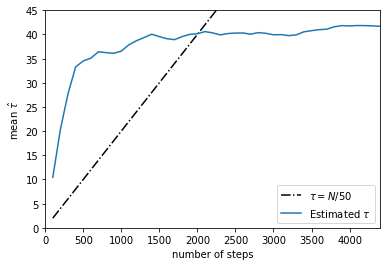

In [29]:
n = 100*np.arange(1, index+1)
y = autocorr[:index]
#plt.plot(n, n / 100.0, "--k", label=r'$\tau = N/100$')
plt.plot(n, n / 50.0, "-.k",label=r'$\tau = N/50$')
plt.plot(n, y, label = r'Estimated $\tau$')
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1*(y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");
plt.legend()
plt.show()

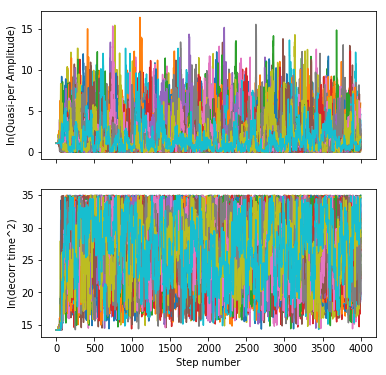

In [63]:
parnames = ["ln(Quasi-per Amplitude)", "ln(decorr time^2)", "Gamma", \
            "ln(Period)"]
fig, axarr = plt.subplots(2, sharex=True, figsize=(6,6))
nsteps = sampler.chain.shape[1]
step = range(nsteps)
for i in range(len(axarr)):
    for w in range(nwalkers):
        axarr[i].plot(step, sampler.chain[w,:,i])
    axarr[i].set_ylabel(parnames[i])
axarr[1].set_xlabel('Step number');

Text(0, 0.5, 'H-alpha')

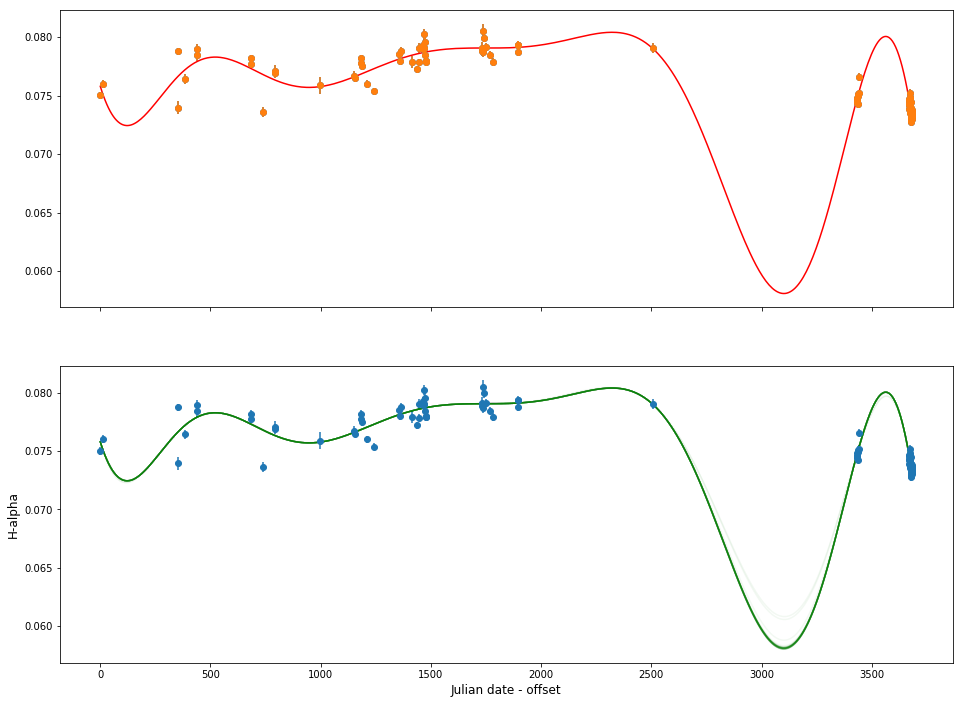

In [58]:
# Make a flat chain of samples with the initial burn-in discarded
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

#set up figure for 5 individual plots
fig, (ax0, ax1) = plt.subplots(2, sharex=True, figsize=(16,12))
tt = np.linspace(alldates[0], alldates[-1], 501, endpoint=True)

# plot individual GPs to check if they are hitting the data
# Choose a sample
n = np.random.randint(0, samples.shape[0])
gp.set_parameter_vector(samples[n])
ax0.plot(tt, gp.sample_conditional(allha, tt), "r")
ax0.errorbar(alldates, allha, yerr=allhaerr, fmt='o')



for i in range(50):
    # Choose a sample
    n = np.random.randint(0, samples.shape[0])
    gp.set_parameter_vector(samples[n])
    # Plot a single sample.
    ax1.plot(tt, gp.sample_conditional(allha, tt), "g", alpha=0.05)
    
# Plot the real data
ax0.errorbar(alldates, allha, yerr=allhaerr, fmt='o')
ax1.errorbar(alldates, allha, yerr=allhaerr, fmt='o')


ax1.set_xlabel("Julian date - offset", fontsize='large')
ax1.set_ylabel("H-alpha", fontsize = 'large')

#ax1.set_ylim(0.072,0.092)

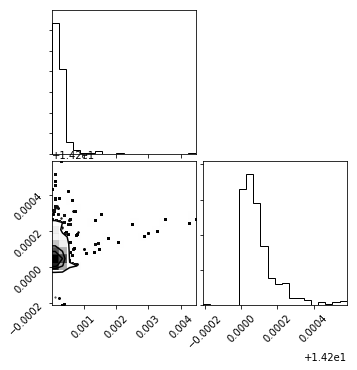

In [47]:
import corner
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
#parnames = ["ln(Quasi-per Amplitude)", "ln(decorr time^2)", "Gamma", \
#            "ln(Period)"]
cfig = corner.corner(samples) #labels=parnames